In [ ]:
import gdown
import re
import multiprocessing
from multiprocessing import Pool, cpu_count, Lock
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_distances, cosine_similarity
from sklearn.manifold import MDS
from sklearn.metrics import pairwise_distances
from concurrent.futures import ProcessPoolExecutor
import nltk
from nltk import pos_tag
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from tqdm import tqdm
from collections import Counter, defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import spacy

In [ ]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

## Loading the cleaned corpus from previous assignment

In [ ]:
file_id = '1WyY7_ZCumaArUhnRiIiVTc2iodU1xakH'
url = f'https://drive.google.com/uc?id={file_id}'

gdown.download(url, 'corpus.txt', quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1WyY7_ZCumaArUhnRiIiVTc2iodU1xakH
From (redirected): https://drive.google.com/uc?id=1WyY7_ZCumaArUhnRiIiVTc2iodU1xakH&confirm=t&uuid=6d1c5ce2-8eb2-4b9f-9ac3-ece173b5767d
To: /content/corpus.txt
100%|██████████| 1.06G/1.06G [00:05<00:00, 198MB/s]


'corpus.txt'

In [ ]:
# Read the contents of the file
with open('corpus.txt', 'r') as file:
    content = file.read()

## Word Count

In [ ]:
def count_words(lines):
    local_counter = Counter()
    for line in lines:
        local_counter.update(line.split())
    return local_counter

## Top 7000 occuring words

In [ ]:
if __name__ == '__main__':
    with open('corpus.txt', 'r', encoding='utf-8') as file:
        lines = file.readlines()

    num_chunks = min(4, len(lines))
    chunk_size = max(1, len(lines) // num_chunks)

    chunks = [lines[i:i + chunk_size] for i in range(0, len(lines), chunk_size)]

    with Pool() as pool:
        results = list(tqdm(pool.imap(count_words, chunks), total=len(chunks)))

    total_counter = Counter()
    for result in results:
        total_counter.update(result)

    top_7000_vocabulary = [word for word, _ in total_counter.most_common(7000)]

100%|██████████| 1/1 [00:36<00:00, 36.02s/it]


## Counts of top 7000 occuring words

In [ ]:
# Function to count total occurrences of words in the content, filtered by top_7000_vocabulary
def count_total_word_occurrences(content, top_vocabulary):
    total_word_counts = Counter()

    # Split the content into words and update the counts
    words = content.split()
    total_word_counts.update(words)

    filtered_counts = {word: total_word_counts[word] for word in top_vocabulary}
    return filtered_counts

In [ ]:
total_word_counts = count_total_word_occurrences(content, top_7000_vocabulary)

## Co-Occurence Count

In [ ]:
# Step 1: Build co-occurrence counts
def build_weighted_cooccurrence_counts(content, top_vocabulary, window_size=4):
    vocab_set = set(top_vocabulary)
    cooccurrence_counts = defaultdict(lambda: defaultdict(int))

    words = content.split()

    for i, word in tqdm(enumerate(words), total=len(words), desc="Building Weighted Co-occurrence Counts"):
        if word in vocab_set:
            # Define the window size
            start_index = max(0, i - window_size)
            end_index = min(len(words), i + window_size + 1)
            context_words = words[start_index:i] + words[i + 1:end_index]

            for j, context_word in enumerate(context_words):
                if context_word in vocab_set:
                    # Calculate weight based on distance
                    distance = max(j - (i - start_index), (i - start_index) - j - 1)
                    weight = window_size - distance
                    cooccurrence_counts[word][context_word] += weight

    return cooccurrence_counts

In [ ]:
cooccurrence_counts = build_weighted_cooccurrence_counts(content, top_7000_vocabulary)

Building Weighted Co-occurrence Counts: 100%|██████████| 125726572/125726572 [12:41<00:00, 165129.33it/s]


In [ ]:
# Empty matrix
matrix = pd.DataFrame(0, index=top_7000_vocabulary, columns=top_7000_vocabulary)

co_occurrence_df = pd.DataFrame.from_dict(cooccurrence_counts, orient='index').fillna(0)

co_occurrence_df = co_occurrence_df.reindex(index=top_7000_vocabulary, columns=top_7000_vocabulary, fill_value=0)

# Add the two DataFrames
matrix = matrix.add(co_occurrence_df, fill_value=0)

In [ ]:
matrix.iloc[:10,:10]

,patients,cells,also,may,study,data,virus,infection,using,used
patients,234050.0,17773.0,49565.0,60630.0,105274.0,39351.0,17312.0,63811.0,18293.0,27218.0
cells,17773.0,263076.0,45352.0,27955.0,13048.0,12781.0,47131.0,53588.0,32012.0,23933.0
also,49565.0,45352.0,7896.0,101987.0,36781.0,28056.0,30870.0,33382.0,13269.0,47295.0
may,60630.0,27955.0,101987.0,34508.0,18974.0,20136.0,27832.0,42310.0,6301.0,23005.0
study,105274.0,13048.0,36781.0,18974.0,57420.0,47275.0,14463.0,22959.0,21594.0,59775.0
data,39351.0,12781.0,28056.0,20136.0,47275.0,95106.0,8525.0,14067.0,58412.0,49952.0
virus,17312.0,47131.0,30870.0,27832.0,14463.0,8525.0,127058.0,98332.0,14133.0,18316.0
infection,63811.0,53588.0,33382.0,42310.0,22959.0,14067.0,98332.0,46726.0,9767.0,11956.0
using,18293.0,32012.0,13269.0,6301.0,21594.0,58412.0,14133.0,9767.0,11386.0,8983.0
used,27218.0,23933.0,47295.0,23005.0,59775.0,49952.0,18316.0,11956.0,8983.0,14486.0


In [ ]:
sparsity = 1 - ((matrix != 0).sum().sum() / matrix.size)

print(f"Sparsity: {sparsity:.4f}")

Sparsity: 0.3794


## Co-Occurrence Ratio matrix
Given, <br>
$$
\begin{align*}
& X_{αβ} \text{ is the number of times word β co-occurs with word α in a given window size (here we took 4, assigning weights accordingly)} \\
& X_{α} = \sum_{k} X_{ak} \text{ is the number of times any word appears in the context of word α} \\
& p_{ik} = \frac{X_{ik}}{X_{i}} \hspace{1cm} p_{jk} = \frac{X_{jk}}{X_{j}} \\
& \frac{p_{ik}}{p_{jk}} = \frac{X_{ik} \times X_{j}}{X_{jk} \times X_{i}} = \frac{P(k|i)}{P(k|j)}
\end{align*}
$$ \\
<!-- Based on above calculations, we make our ratio matrix in below format: \\
|                       | i = patients |   i = cells |  i = also |
|-----------------------|--------------|-------------|-----------|
| $p(k|ice)/p(k|steam)$ |      xxx     |     xxx     |    xxx    |
| $p(k|ice)/p(k|steam)$ |      xxx     |     xxx     |    xxx    |
| $p(k|ice)/p(k|steam)$ |      xxx     |     xxx     |    xxx    |
| $p(k|ice)/p(k|steam)$ |      xxx     |     xxx     |    xxx    |
-->



In [ ]:
# Calculate the sum of each row and store it in a new Series X
X = matrix.sum(axis=1)

X_df = X.reset_index()
X_df.columns = ['Vocabulary', 'RowSum']
Xi_values = X.to_dict()

In [ ]:
# Convert defaultdict to dict
cooccurrence_counts = {key: dict(value) for key, value in cooccurrence_counts.items()}

In [ ]:
# Step 2: Calculate the co-occurrence ratio matrix
# In each case k was choosen to get largest X_ik
def cooccurrence_ratio_matrix(cooccurrence_counts, top_vocabulary, Xi_values):
    matrix_size = len(top_vocabulary)
    cooccurrence_matrix = np.eye(matrix_size)

    # Create a mapping from words to indices
    word_to_index = {word: index for index, word in enumerate(top_vocabulary)}

    # Precompute max keys for each word
    max_keys = {word: max(cooccurrence_counts[word], key=cooccurrence_counts[word].get) for word in top_vocabulary}

    # Use a single loop for all pairs (i, j) where i < j
    for i in tqdm(range(matrix_size), desc="Calculating co-occurrence ratios"):
        word = top_vocabulary[i]
        max_key = max_keys[word]
        max_value = cooccurrence_counts[word][max_key]

        for j in range(i + 1, matrix_size):  # Start from i + 1 to avoid duplication
            context_word = top_vocabulary[j]
            max_key_context = max_keys[context_word]
            max_value_context = cooccurrence_counts[context_word][max_key_context]

            if max_value > 0 and max_value_context > 0:
                cooccurrence_matrix[i, j] = (max_value * Xi_values[context_word]) / (max_value_context * Xi_values[word])
                cooccurrence_matrix[j, i] = (max_value_context * Xi_values[word]) / (max_value * Xi_values[context_word])

    cooccurrence_df = pd.DataFrame(cooccurrence_matrix, index=top_vocabulary, columns=top_vocabulary)
    cooccurrence_df = cooccurrence_df.round(3)

    return cooccurrence_df

In [ ]:
cooccurrence_matrix = cooccurrence_ratio_matrix(cooccurrence_counts, top_7000_vocabulary, Xi_values)

Calculating co-occurrence ratios: 100%|██████████| 7000/7000 [00:27<00:00, 252.97it/s] 


## Vocabulary and size of Co-occurence Ratio Matrix

In [ ]:
# Vocabulary
cooccurrence_matrix.columns[:10]

Index(['patients', 'cells', 'also', 'may', 'study', 'data', 'virus',
       'infection', 'using', 'used'],
      dtype='object')

In [ ]:
# Dimensions
cooccurrence_matrix.shape

(7000, 7000)

In [ ]:
cooccurrence_matrix.iloc[:10,:10]

,patients,cells,also,may,study,data,virus,infection,using,used
patients,1.000,0.574,1.463,1.403,1.279,1.354,0.883,1.293,1.427,1.795
cells,1.742,1.000,2.547,2.443,2.227,2.357,1.539,2.251,2.485,3.127
also,0.684,0.393,1.000,0.959,0.874,0.926,0.604,0.884,0.976,1.228
may,0.713,0.409,1.043,1.000,0.912,0.965,0.630,0.922,1.017,1.280
study,0.782,0.449,1.144,1.097,1.000,1.058,0.691,1.011,1.116,1.404
data,0.739,0.424,1.080,1.036,0.945,1.000,0.653,0.955,1.054,1.326
virus,1.132,0.650,1.656,1.588,1.448,1.532,1.000,1.463,1.615,2.032
infection,0.774,0.444,1.131,1.085,0.989,1.047,0.683,1.000,1.104,1.389
using,0.701,0.402,1.025,0.983,0.896,0.949,0.619,0.906,1.000,1.258
used,0.557,0.320,0.815,0.781,0.712,0.754,0.492,0.720,0.795,1.000


## Five nouns and verbs relevant to COVID19

In [ ]:
verbs = ["contain", "test", "isolate", "transmit", "mitigate"]
nouns = ["virus", "pandemic", "vaccine", "variant", "quarantine"]

## Generate five similar words for each (noun and verb chosen in previous step) and display the result with cosine distance for each one

In [ ]:
# Install if needed
# !python -m spacy download en_core_web_md

In [ ]:
nlp = spacy.load("en_core_web_md")

all_words = verbs + nouns

In [ ]:
def get_similar_words(word):
    if word in nlp.vocab and nlp.vocab[word].has_vector:
        # Get the word vector
        word_vector = nlp.vocab[word].vector
        # Calculate similarities with words that have vectors
        similar_words = sorted(
            nlp.vocab,
            key=lambda w: w.vector @ word_vector,
            reverse=True
        )
        # Select the top 5 similar words (excluding the original word)
        similar = [(w.text, round((w.vector @ word_vector), 4)) for w in similar_words if w.has_vector and w.is_lower and w.text != word][:5]
        return {word: similar}
    return {word: []}

In [ ]:
if __name__ == "__main__":
    chunk_size = 1000  # Smaller chunks for better performance
    chunks = [content[i:i + chunk_size] for i in range(0, len(content), chunk_size)]

    for chunk in tqdm(chunks, desc="Processing chunks"):
        nlp(chunk)

    # Get similar words for all words
    similar_words_results = {}
    for word in tqdm(all_words, desc="Finding similar words"):
        similar_words_results.update(get_similar_words(word))

Processing chunks: 0it [00:00, ?it/s]
Finding similar words: 100%|██████████| 10/10 [00:00<00:00, 82241.25it/s]


In [ ]:
for word, similar in similar_words_results.items():
        print(f"{word}: {similar}")

contain: ['control', 'limit', 'suppress', 'manage', 'restrict']
test: ['screen', 'evaluate', 'assess', 'analyze', 'examine']
isolate: ['quarantine', 'segregate', 'separate', 'seclude', 'detach']
transmit: ['spread', 'convey', 'communicate', 'transfer', 'propagate']
mitigate: ['alleviate', 'reduce', 'lessen', 'diminish', 'soften']
virus: ['pathogen', 'germ', 'microbe', 'agent', 'infectious']
pandemic: ['epidemic', 'outbreak', 'crisis', 'health emergency', 'global event']
vaccine: ['immunization', 'inoculation', 'shot', 'serum', 'preventative']
variant: ['mutation', 'strain', 'type', 'version', 'form']
quarantine: ['isolation', 'seclusion', 'lockdown', 'confinement', 'restriction']


##  Multi-Dimensional Scaling to visualize certain concepts

In [ ]:
concepts = ['vaccine', 'test', 'transmit']
vaccine_terms = ['immunization', 'inoculation', 'serum']
test_terms = ['screen', 'evaluate', 'assess', 'analyze', 'examine']
transmit_terms = ['spread', 'communicate', 'transfer']

In [ ]:
# Combine everything into a single list
all_terms = concepts + vaccine_terms + test_terms + transmit_terms
corpus = [content]

In [ ]:
# Create TF-IDF matrix
vectorizer = TfidfVectorizer(vocabulary=all_terms)
tfidf_matrix = vectorizer.fit_transform(corpus)

In [ ]:
# Step 2: Compute Similarities
# Create a DataFrame for the terms
term_matrix = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

# Compute pairwise cosine similarity
similarity_matrix = term_matrix.T.dot(term_matrix)

In [ ]:
# Step 3: Perform MDS
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
pos = mds.fit_transform(1 - similarity_matrix)  # Convert similarity to dissimilarity

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


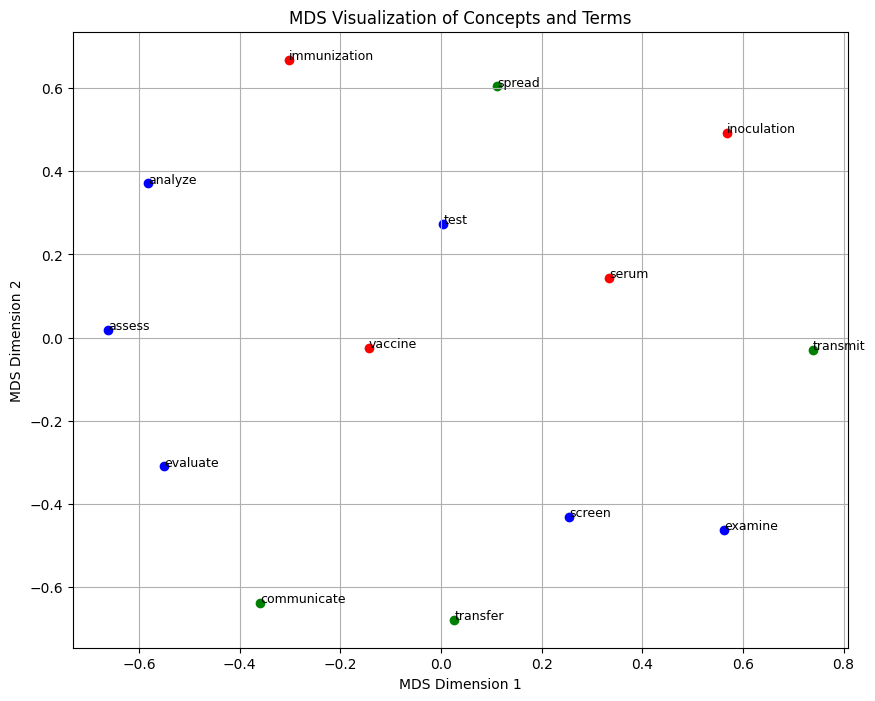

In [ ]:
# Visualization
colors = {'vaccine': 'red', 'test': 'blue', 'transmit': 'green'}
plt.figure(figsize=(10, 8))

for i, term in enumerate(all_terms):
    if term in concepts:
        color = colors[term]
    else:
        if term in vaccine_terms:
            color = colors['vaccine']
        elif term in test_terms:
            color = colors['test']
        else:
            color = colors['transmit']

    plt.scatter(pos[i, 0], pos[i, 1], c=color, label=term)

for i, term in enumerate(all_terms):
    plt.annotate(term, (pos[i, 0], pos[i, 1]), fontsize=9)

plt.title('MDS Visualization of Concepts and Terms')
plt.xlabel('MDS Dimension 1')
plt.ylabel('MDS Dimension 2')
plt.grid()
plt.show()